# Context
This is the dataset that is used for the paper " A data-driven approach to predict the success of bank telemarketing ".

IMHO it's a good dataset for training oneself in M.L. by building one classifier. After you can compare your results with the paper.

# Content
Input variables:

#### bank client data:

- age (numeric) 
- job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
- marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
- education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
- default: has credit in default? (categorical: 'no','yes','unknown')
- housing: has housing loan? (categorical: 'no','yes','unknown') 
- loan: has personal loan? (categorical: 'no','yes','unknown')

#### related with the last contact of the current campaign:

- contact: contact communication type (categorical: 'cellular','telephone')
- month: last contact month of year (categorical: 'jan', 'feb', 'mar', …, 'nov', 'dec')
- dayofweek: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
- duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

#### other attributes:

- campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
- pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
- previous: number of contacts performed before this campaign and for this client (numeric)
- poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

#### social and economic context attributes

- emp.var.rate: employment variation rate - quarterly indicator (numeric)
- cons.price.idx: consumer price index - monthly indicator (numeric)
- cons.conf.idx: consumer confidence index - monthly indicator (numeric)
- euribor3m: euribor 3 month rate - daily indicator (numeric)
- nr.employed: number of employees - quarterly indicator (numeric)

#### Output variable (desired target):

- y - has the client subscribed a term deposit? (binary: 'yes','no')

# Citation Request (Acknowledgements)
This dataset is public available for research. The details are described in [Moro et al., 2014].
Please include this citation if you plan to use this database:

[Moro et al., 2014] S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from matplotlib import rcParams
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score
# import xgboost as xgb, XGBClassifier
from xgboost import XGBClassifier
%matplotlib inline

rcParams['figure.figsize'] = 17,10

In [3]:
df = pd.read_csv("bank-additional.csv")
# df['y'] = df.y.map({'yes': 1, 'no': 0})

In [4]:
def plot_graphs(col, df):
    # Set Figsize
    if len(df[col].value_counts()) > 5:
        fig, ax = plt.subplots(2, sharex=True, figsize=(10, 10))
    else:
        fig, ax = plt.subplots(1, 2, figsize=(7, 5))
        fig.tight_layout()

    # Plot Histogram
    sns.countplot(data=df, x=col, ax=ax[0], color='C0')
    for i, p in enumerate(ax[0].patches):
        ax[0].annotate(f'{p.get_height()}', (p.get_x()+0.1, p.get_height()+5))
    ax[0].set_title(f"{col.title()} Histogram")
    # ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=40, ha="right")

    # Plot y distribution on feature
    Y = df[col]
    total = len(Y)
    sns.countplot(x=col, data=df, hue="y")
    for i, p in enumerate(ax[1].patches):
        percent = (p.get_height() / total) * 100
        ax[1].annotate(f'{percent:.2f}%', (p.get_x()+0.1, p.get_height()+5))

    ax[1].set_yticklabels(map('{:.1f}%'.format, 100*ax[1].yaxis.get_majorticklocs()/total))
    ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=10, ha="right")
    ax[1].set_title(f"y distribution on {col.title()}")
    plt.show()
    # fig.savefig(f'bank-telemarketing-prediction/images/hist_{col}.png')
    # plt.close(fig)

In [5]:
numerics = df.select_dtypes(include=np.number).columns.tolist()
categorical = [col for col in df.columns if col not in numerics]

In [1]:
# for cat in categorical:
#     print('cat', cat)
#     plot_graphs(cat, df)


In [27]:
def plot_numeric_graphs(col, df):
    fig, ax = plt.subplots(2, figsize=(7, 10))
    sns.boxplot(x='y', y=col, data=df, ax=ax[0])
    sns.histplot(df[col], kde=True)
    plt.show()
    fig.savefig(f'bank-telemarketing-prediction/images/hist_{col.replace(".", "_")}.png')
    plt.close(fig)

In [29]:
# for num in numerics:
#     plot_numeric_graphs(num, df)

In [37]:
# sns.heatmap(df.corr(), cmap="BuPu", square=True, annot=True, linewidth=0.1)
# plt.title("Pearson correlation of Features", y=1.05, size=15)
# plt.show()
# plt.savefig('bank-telemarketing-prediction/images/heatmap_corr.png')

In [3]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
count,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000
mean,40.113620,256.788055,2.537266,960.422190,0.190337,0.084972,93.579704,-40.499102,3.621356,5166.481695,0.109493
std,10.313362,254.703736,2.568159,191.922786,0.541788,1.563114,0.579349,4.594578,1.733591,73.667904,0.312294
min,18.000000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.635000,4963.600000,0.000000
25%,32.000000,103.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.334000,5099.100000,0.000000
50%,38.000000,181.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000,0.000000
75%,47.000000,317.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,0.000000
max,88.000000,3643.000000,35.000000,999.000000,6.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,1.000000


In [4]:
numerics = df.select_dtypes(include=np.number).columns.tolist()
categorical = [col for col in df.columns if col not in numerics]

In [5]:
df_encoded = df.copy()

In [6]:
label = LabelEncoder()
for cat in categorical:
    label.fit(df_encoded[cat])
    df_encoded[cat] = label.transform(df_encoded[cat])
df_encoded

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,1,1,2,0,2,0,0,6,0,...,2,999,0,1,-1.8,92.893,-46.2,1.313,5099.1,0
1,39,7,2,3,0,0,0,1,6,0,...,4,999,0,1,1.1,93.994,-36.4,4.855,5191.0,0
2,25,7,1,3,0,2,0,1,4,4,...,1,999,0,1,1.4,94.465,-41.8,4.962,5228.1,0
3,38,7,1,2,0,1,1,1,4,0,...,3,999,0,1,1.4,94.465,-41.8,4.959,5228.1,0
4,47,0,1,6,0,2,0,0,7,1,...,1,999,0,1,-0.1,93.200,-42.0,4.191,5195.8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4114,30,0,1,1,0,2,2,0,3,2,...,1,999,0,1,1.4,93.918,-42.7,4.958,5228.1,0
4115,39,0,1,3,0,2,0,1,3,0,...,1,999,0,1,1.4,93.918,-42.7,4.959,5228.1,0
4116,27,8,2,3,0,0,0,0,6,1,...,2,999,1,0,-1.8,92.893,-46.2,1.354,5099.1,0
4117,58,0,1,3,0,0,0,0,1,0,...,1,999,0,1,1.4,93.444,-36.1,4.966,5228.1,0


In [7]:
X = df_encoded.drop(columns=['y'])
y = df_encoded.y.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [8]:
log_reg = sm.Logit(y_train, X_train).fit()
print(log_reg.summary())
# print(log_reg.featuer)
yhat = log_reg.predict(X_test)
prediction = list(map(round, yhat))
cm1 = confusion_matrix(y_test, prediction)
print ("Confusion Matrix : \n", cm1)
print('Test accuracy = ', accuracy_score(y_test, prediction))

Optimization terminated successfully.
         Current function value: 0.198627
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 2759
Model:                          Logit   Df Residuals:                     2739
Method:                           MLE   Df Model:                           19
Date:                Sat, 25 Sep 2021   Pseudo R-squ.:                  0.4236
Time:                        22:29:26   Log-Likelihood:                -548.01
converged:                       True   LL-Null:                       -950.82
Covariance Type:            nonrobust   LLR p-value:                1.377e-158
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
age                0.0068      0.008      0.890      0.374      -0.008       0.022
job              

In [9]:
X.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed'],
      dtype='object')

Confusion Matrix : 
 [[1172   38]
 [  86   64]]
Test accuracy =  0.9088235294117647
top_three [16 14  7]
Feature: 0, Score: 0.00884, Name: age
Feature: 1, Score: 0.01064, Name: job
Feature: 2, Score: 0.22763, Name: marital
Feature: 3, Score: 0.06957, Name: education
Feature: 4, Score: 0.09415, Name: default
Feature: 5, Score: 0.03021, Name: housing
Feature: 6, Score: 0.16517, Name: loan
Feature: 7, Score: 0.82341, Name: contact
Feature: 8, Score: 0.10075, Name: month
Feature: 9, Score: 0.10806, Name: day_of_week
Feature: 10, Score: 0.00534, Name: duration
Feature: 11, Score: 0.01540, Name: campaign
Feature: 12, Score: 0.00064, Name: pdays
Feature: 13, Score: 0.07535, Name: previous
Feature: 14, Score: 0.61056, Name: poutcome
Feature: 15, Score: 0.19203, Name: emp.var.rate
Feature: 16, Score: 0.54390, Name: cons.price.idx
Feature: 17, Score: 0.06773, Name: cons.conf.idx
Feature: 18, Score: 0.12420, Name: euribor3m
Feature: 19, Score: 0.01016, Name: nr.employed


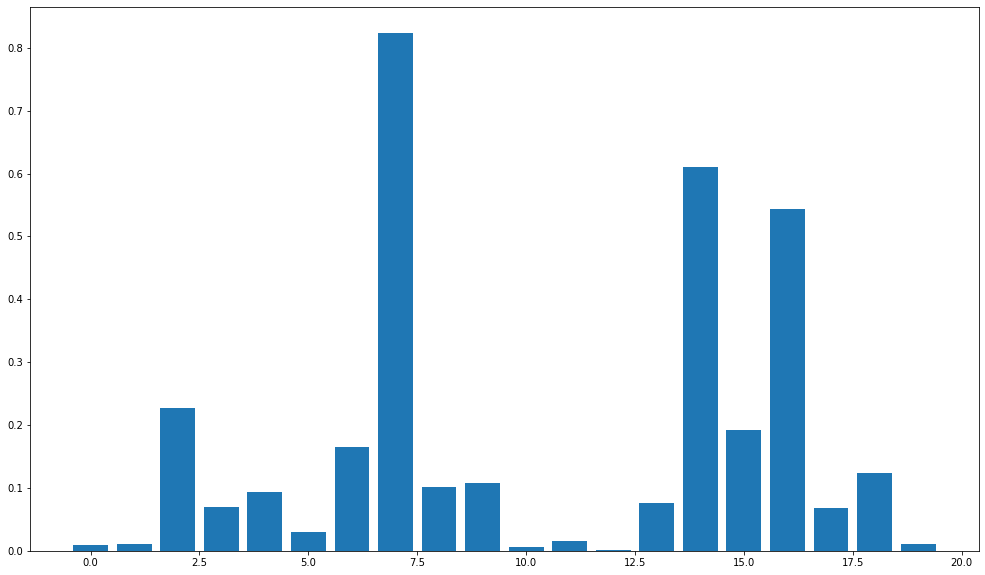

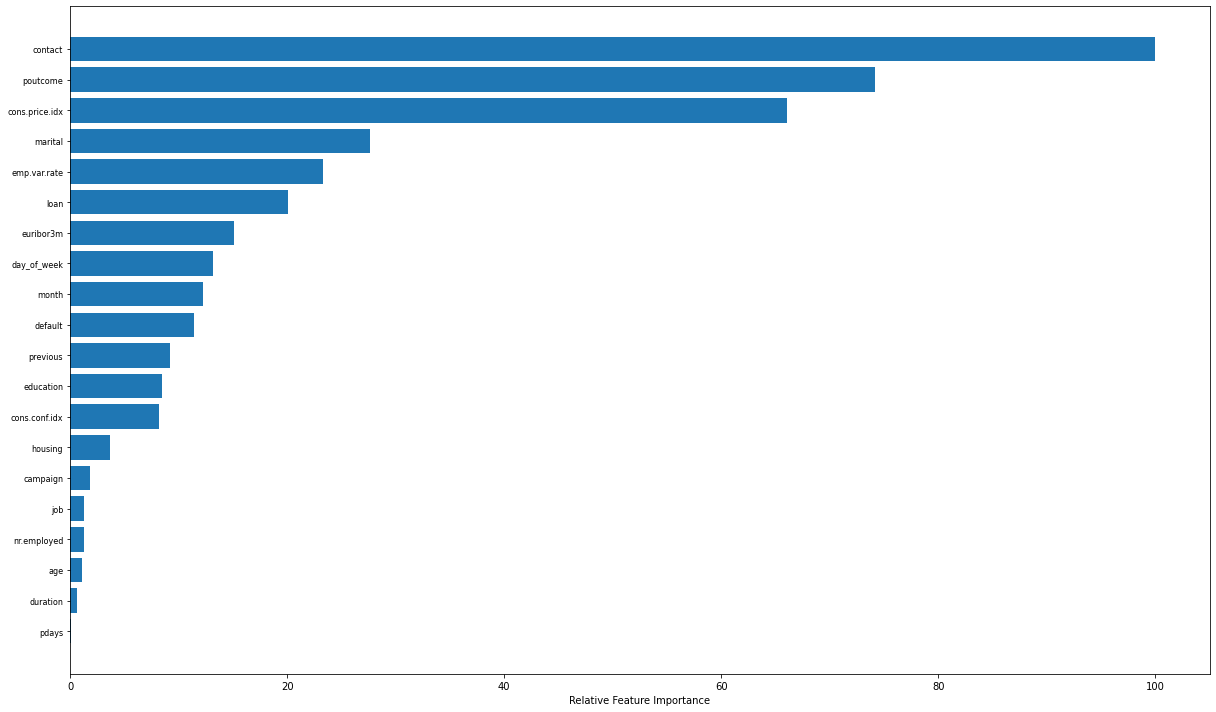

In [10]:
model_lr = LogisticRegression(max_iter=10000)
model_lr.fit(X_train, y_train)
y_pred = model_lr.predict(X_test)
cm1 = confusion_matrix(y_test, y_pred)
print ("Confusion Matrix : \n", cm1)
print('Test accuracy = ', accuracy_score(y_test, y_pred))

importance = abs(model_lr.coef_[0])
top_three = np.argpartition(importance, -3)[-3:]
print("top_three", top_three)
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f, Name: %s' % (i,v, X.columns[i]))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

feature_importance = abs(model_lr.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure()
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance')

plt.tight_layout()   
plt.show()

In [6]:
x_cfl = XGBClassifier(tree_method='gpu_hist', max_bin=16)
xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}
random_cfl=cross_val_score(x_cfl,param_distributions=xgb_params,verbose=10,n_iter=20, cv=10, scoring='roc_auc')
scores = cross_val_score(XGBRegressor(), X, y, scoring='neg_mean_squared_error')
random_cfl.fit(X_train, y_train)
print (random_cfl.best_params_)
# dtrain = xgb.DMatrix(X_train, y_train, feature_names = X_train.columns)
# model = xgb.train(dict(xgb_params,silent=0),dtrain,num_boost_round=100)

# fig,ax=plt.subplots(figsize = (13,19))
# xgb.plot_importance(model, max_num_features=50, height=0.5, ax=ax)
# plt.show()

TypeError: cross_val_score() got an unexpected keyword argument 'param_distributions'

<AxesSubplot:xlabel='contact', ylabel='count'>

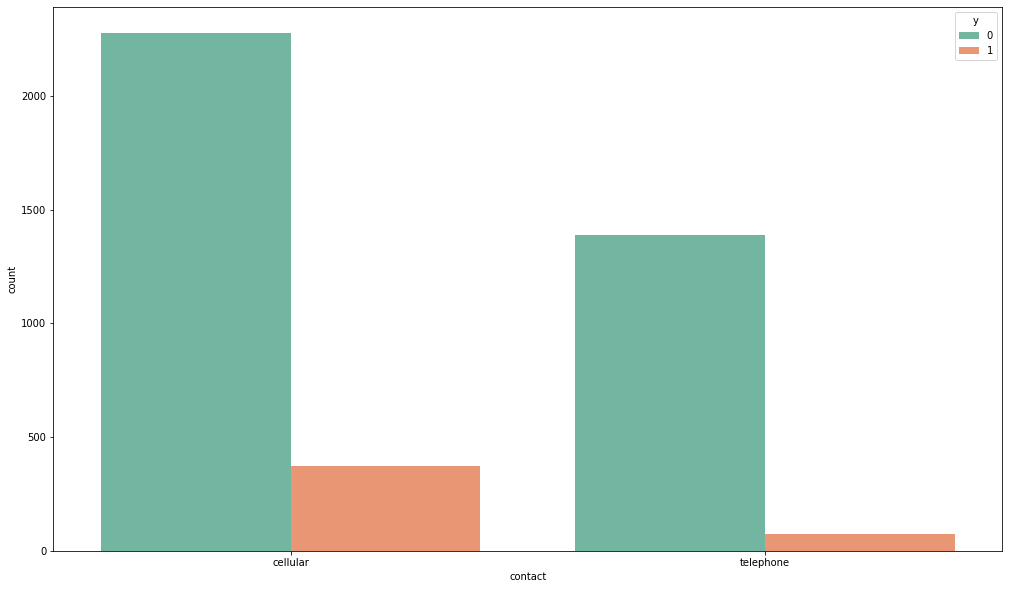

In [46]:
# numerics = ["age", "campaign", "pdays", "previous", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed", "y"]
# categorical = ["job", "marital", "education", "default", "housing",	"loan",	"contact", "month",	"day_of_week", "duration", "poutcome"]
# df_numerics = df.drop(columns=categorical)
# df_numerics
sns.countplot(x=df['contact'],hue=df['y'],palette="Set2")

<AxesSubplot:xlabel='job'>

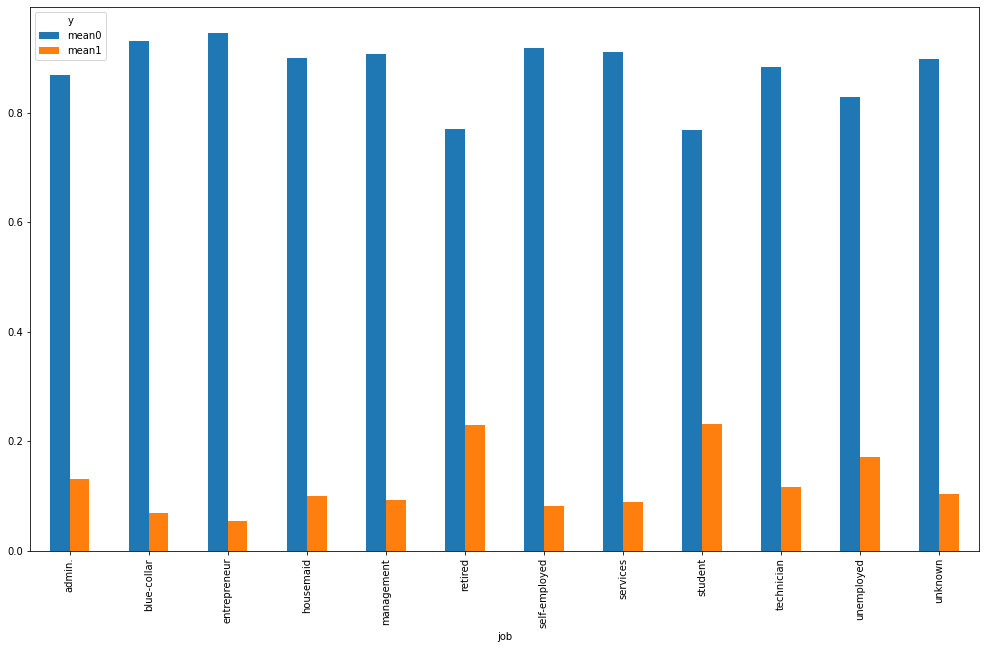

In [33]:
dfaa = df.groupby(['job','y']).size()
dfaa = dfaa.unstack()
dfaa["mean0"] = dfaa.loc[:, 0] / (dfaa.loc[:, 0] + dfaa.loc[:, 1])
dfaa["mean1"] = dfaa.loc[:, 1] / (dfaa.loc[:, 0] + dfaa.loc[:, 1])
dfaa[['mean0', 'mean1']].plot(kind='bar')

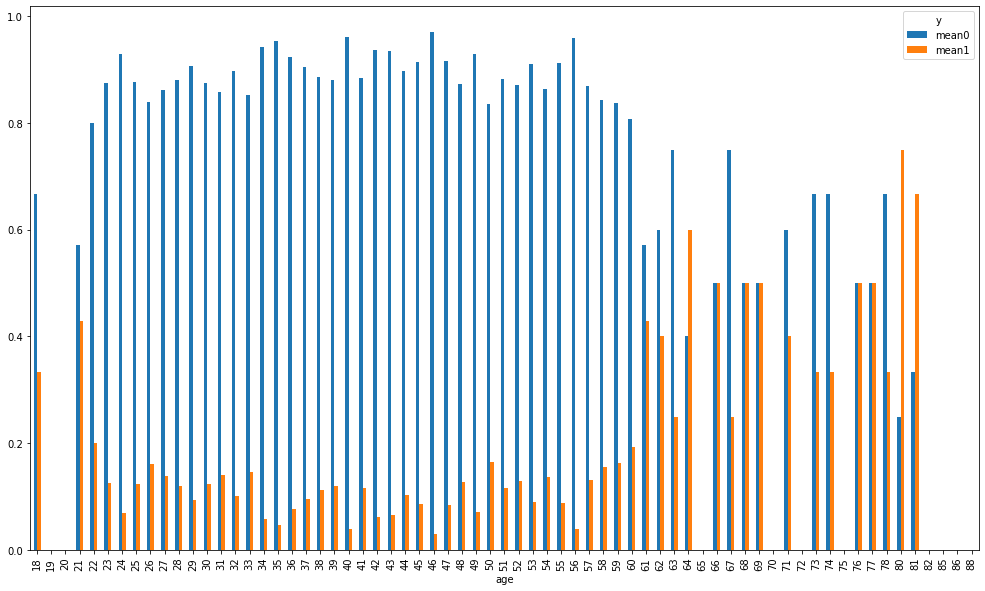

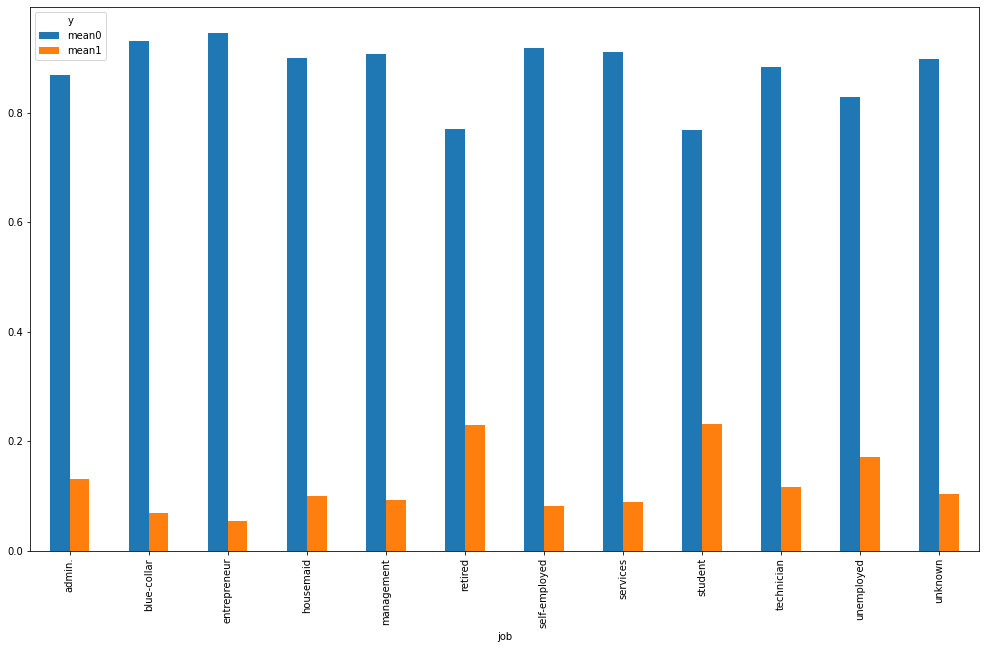

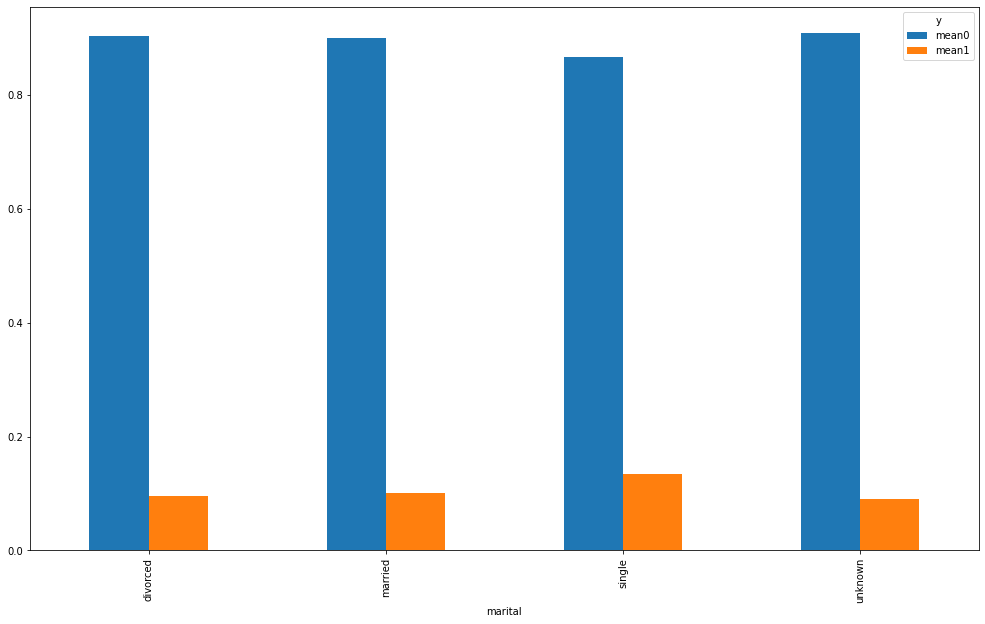

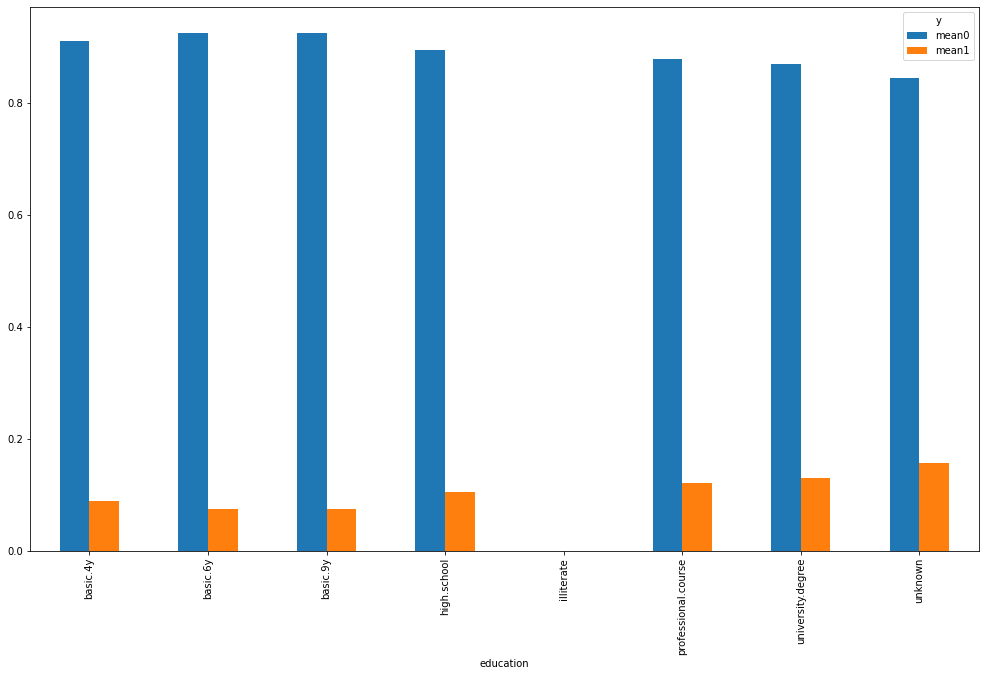

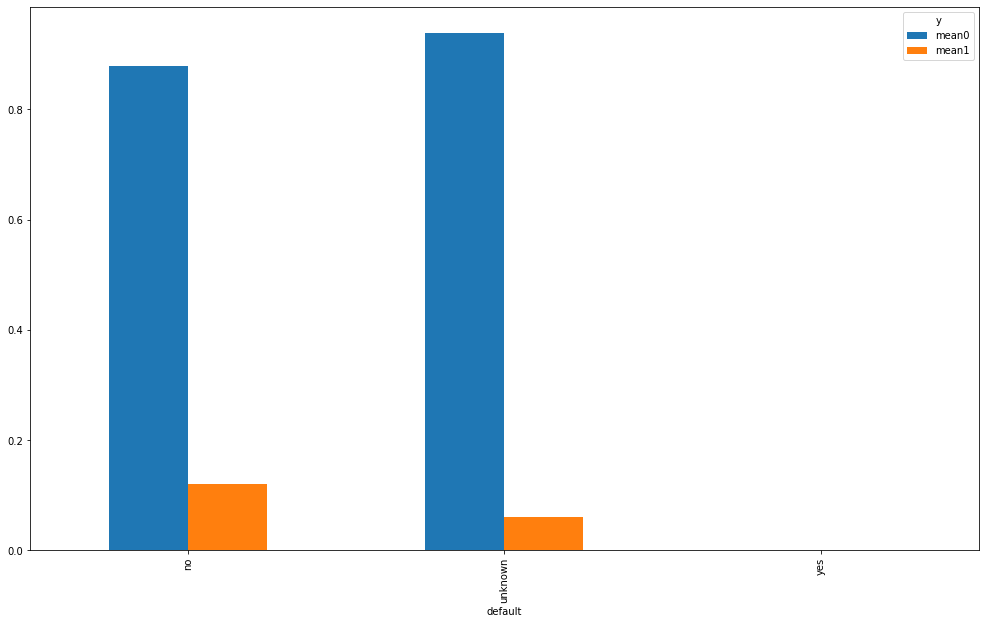

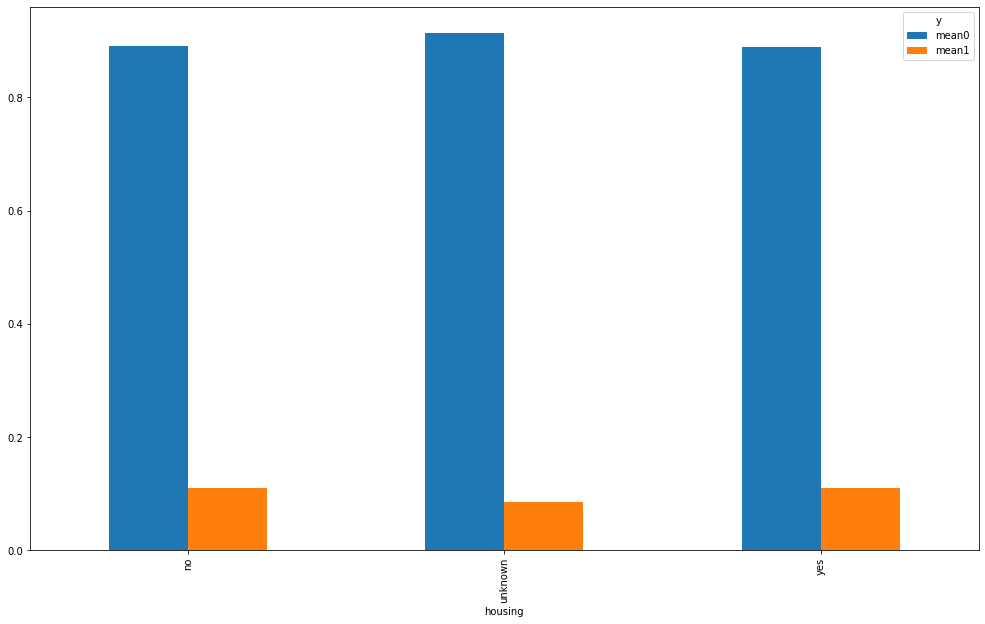

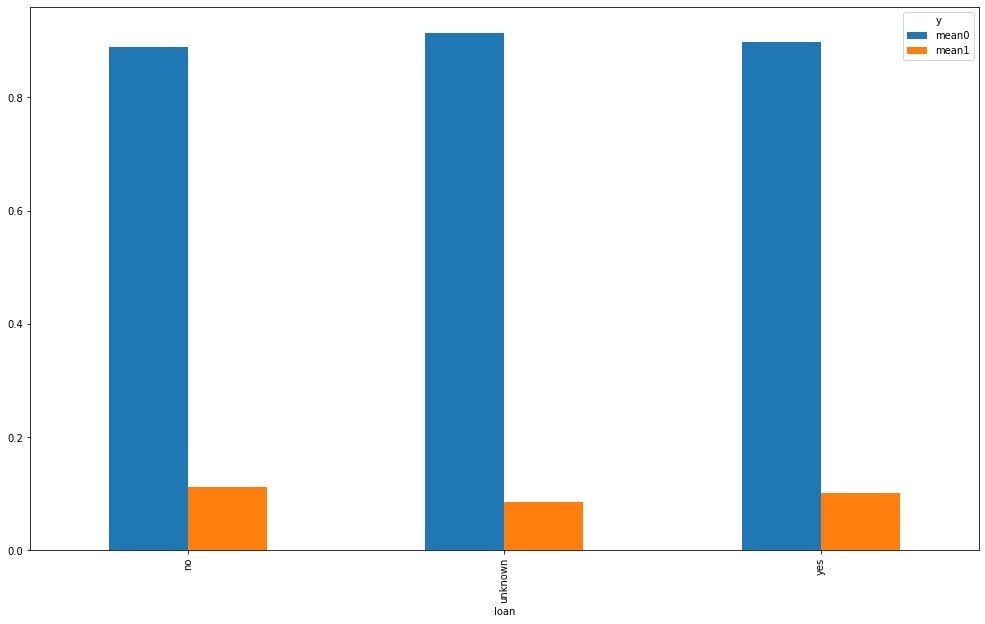

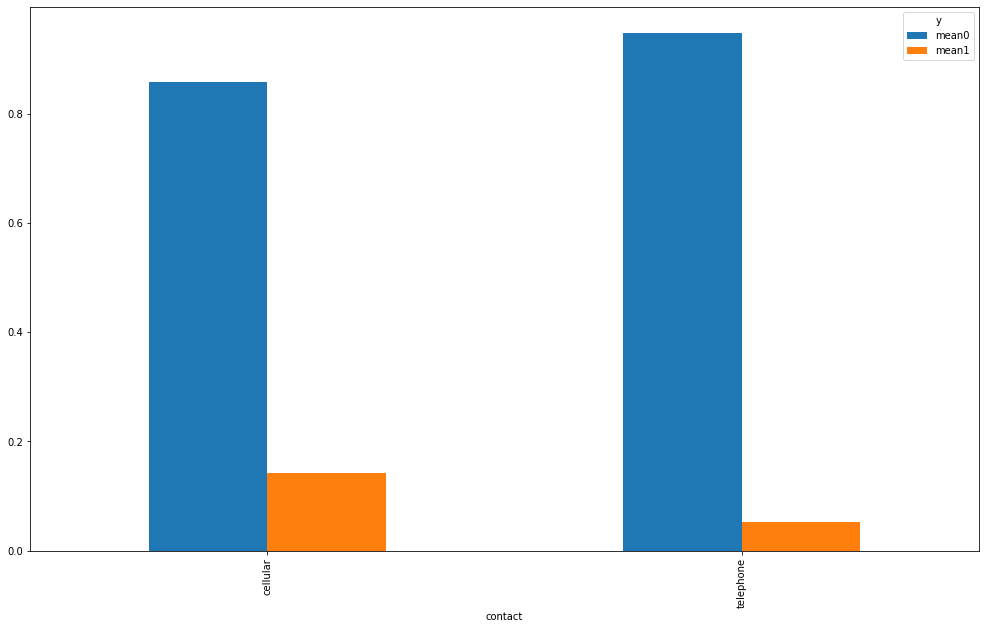

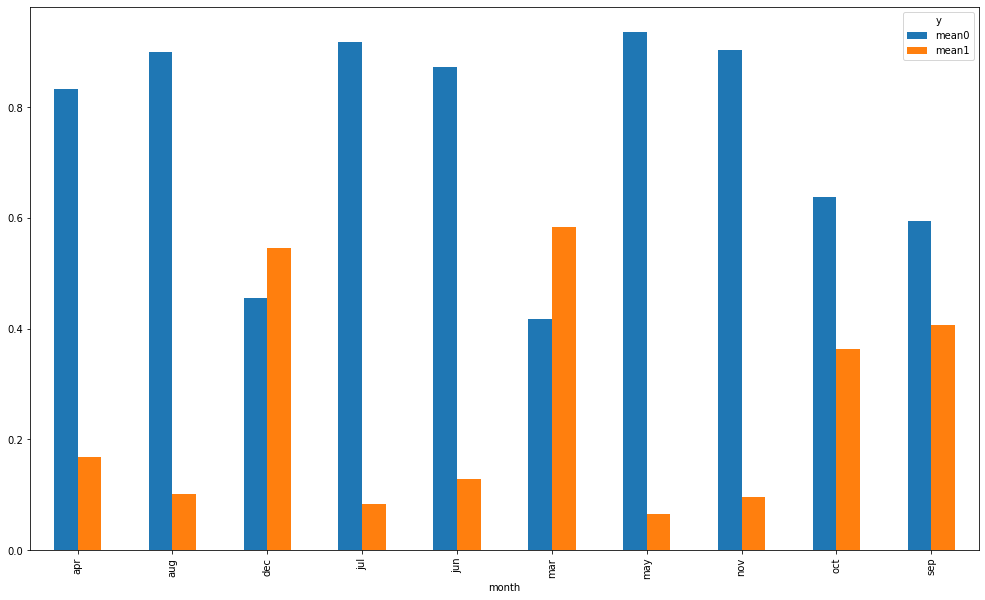

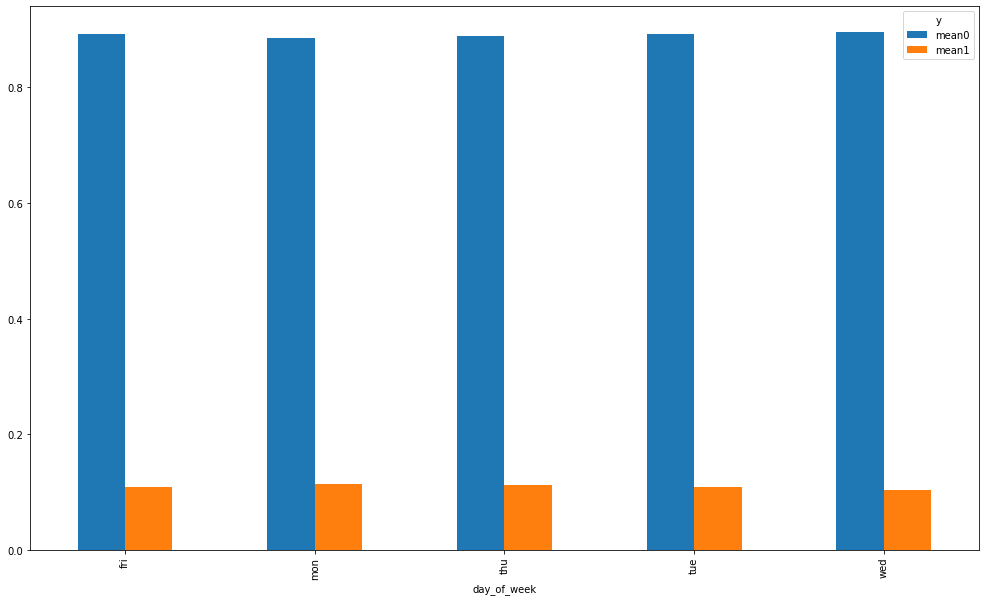

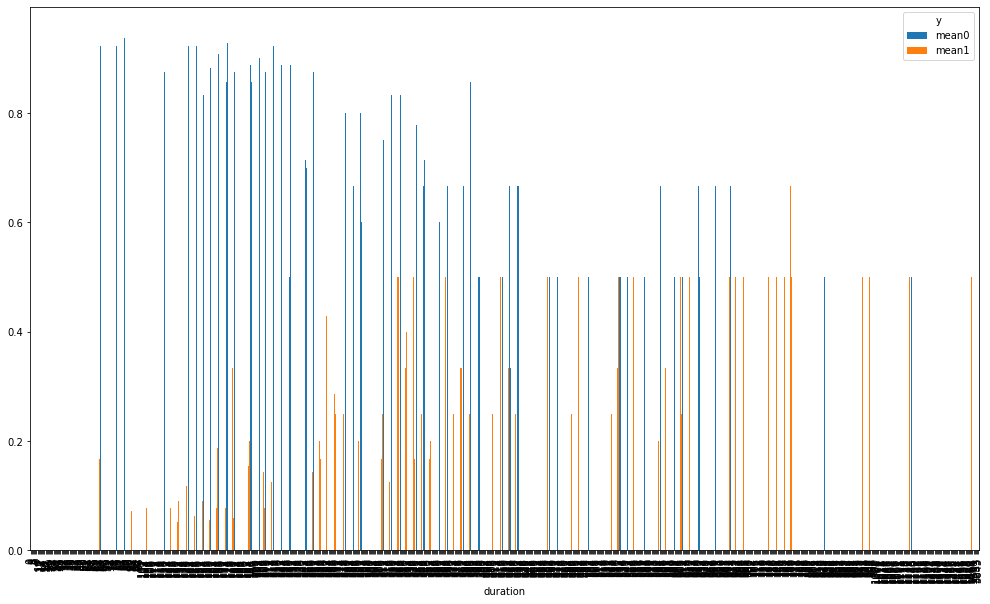

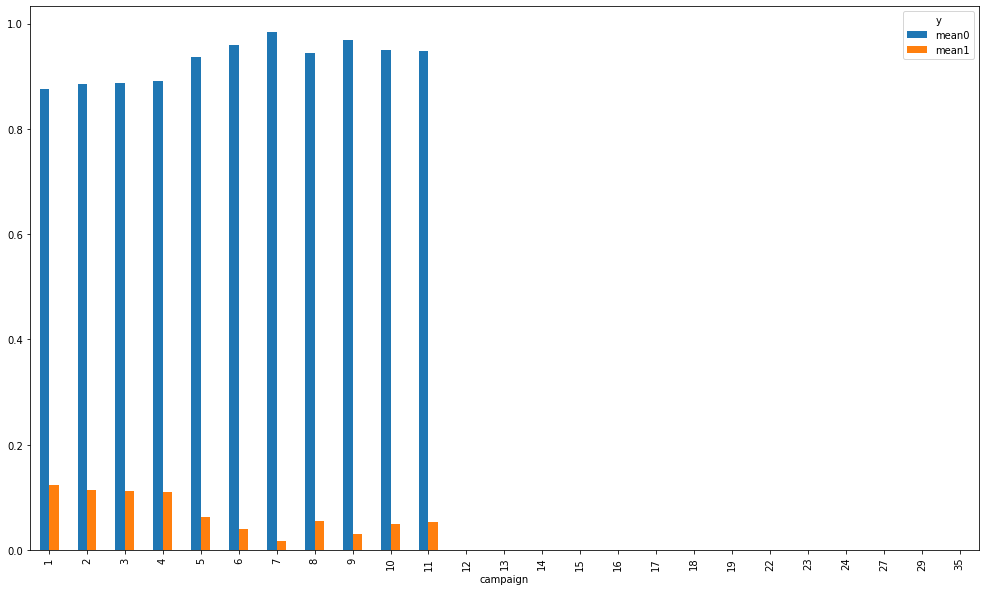

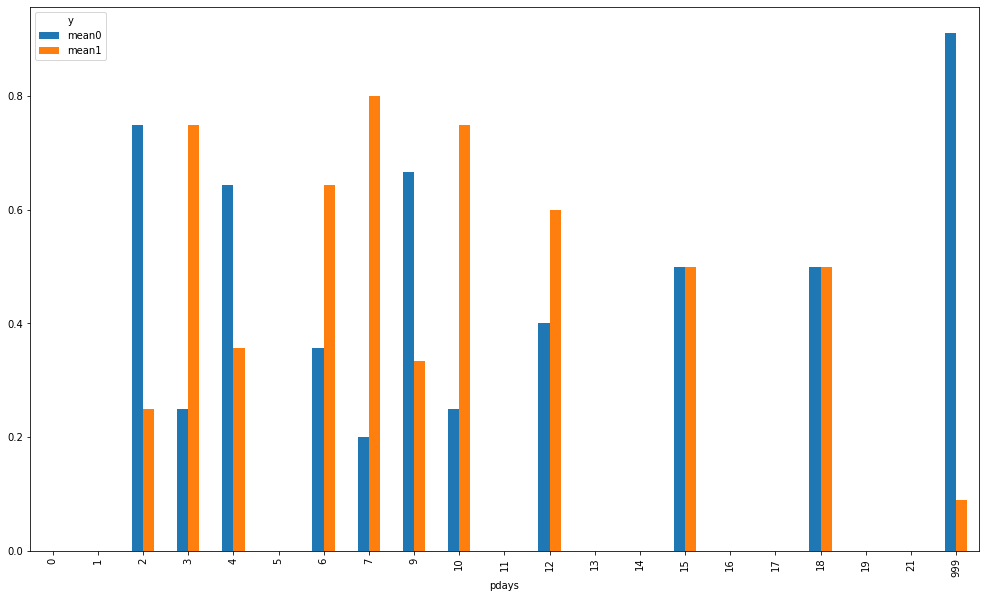

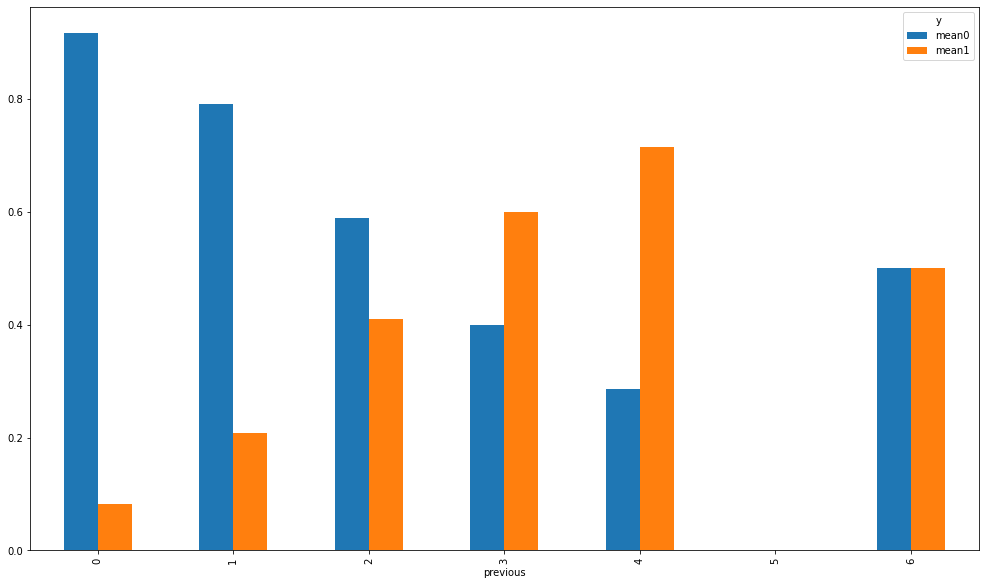

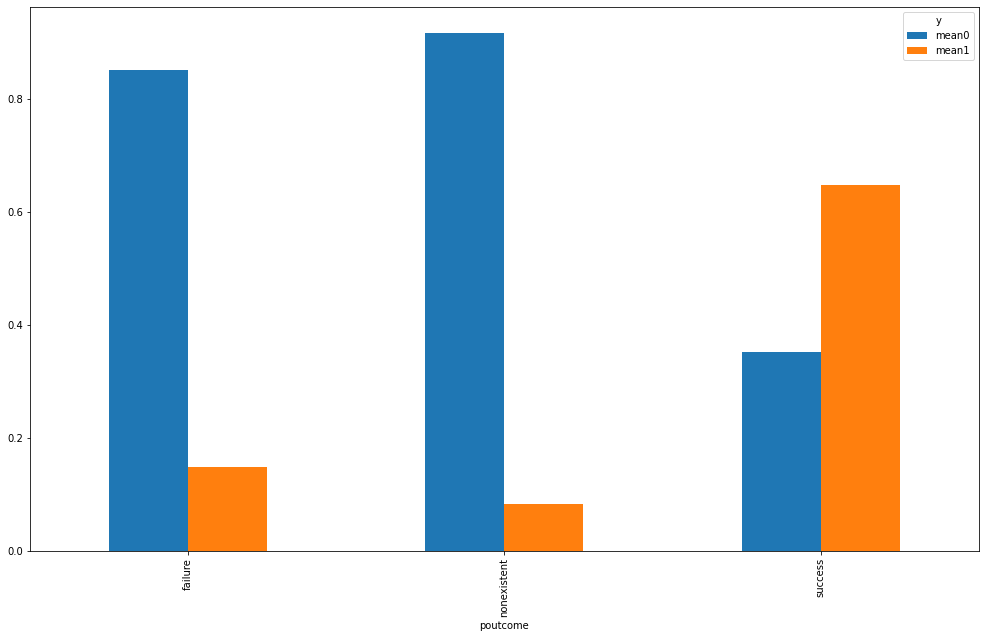

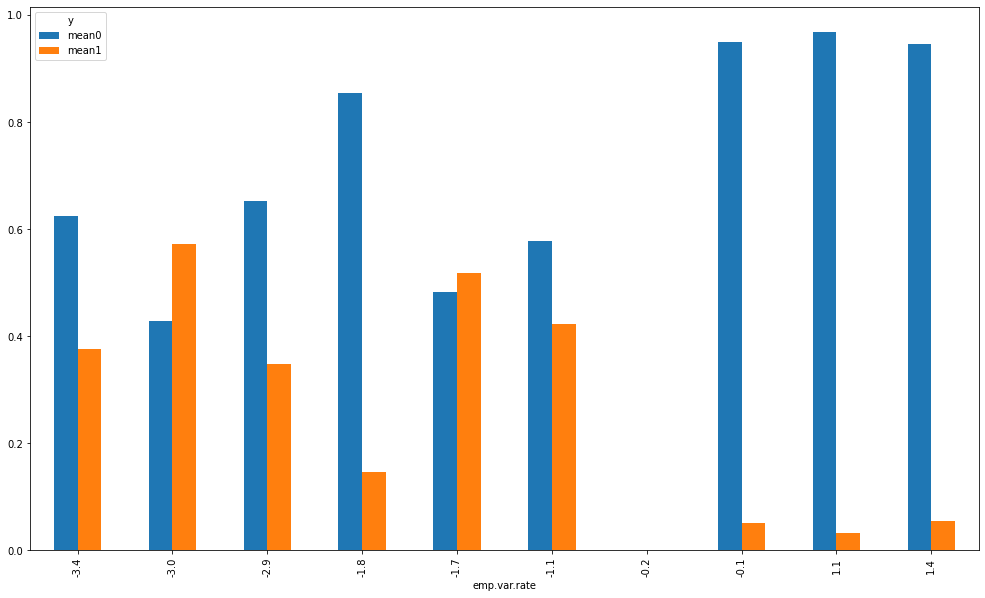

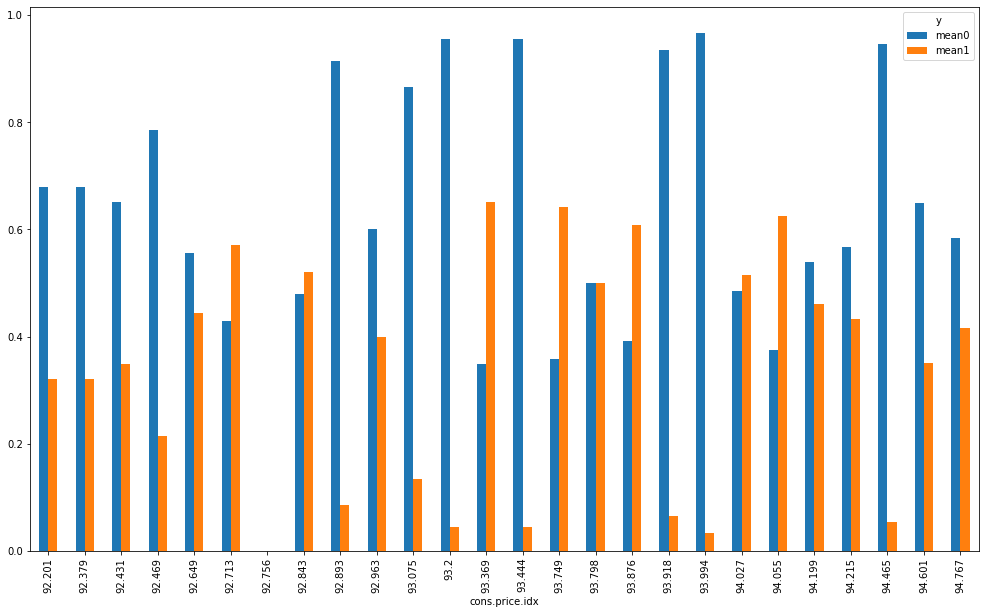

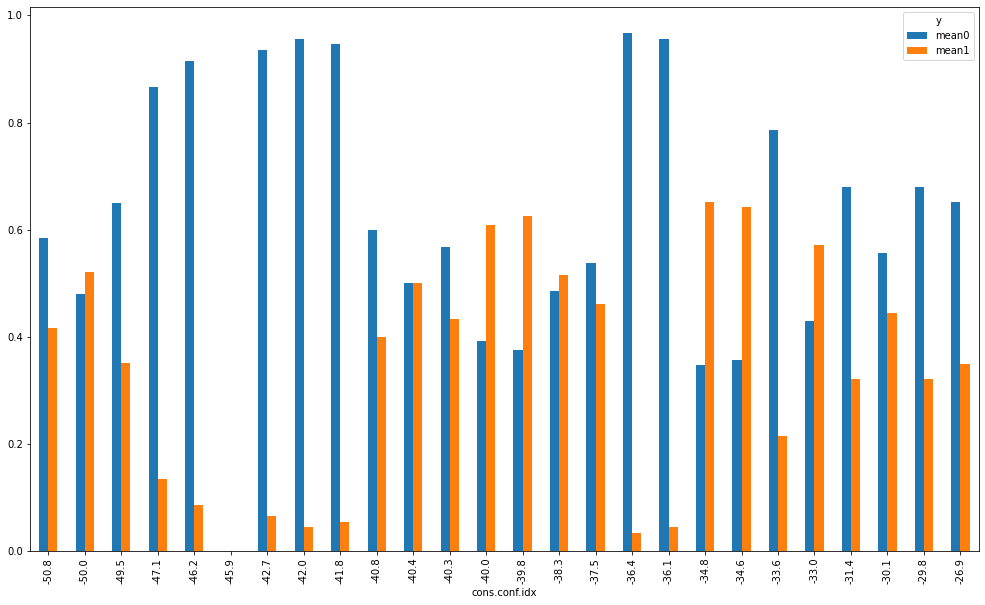

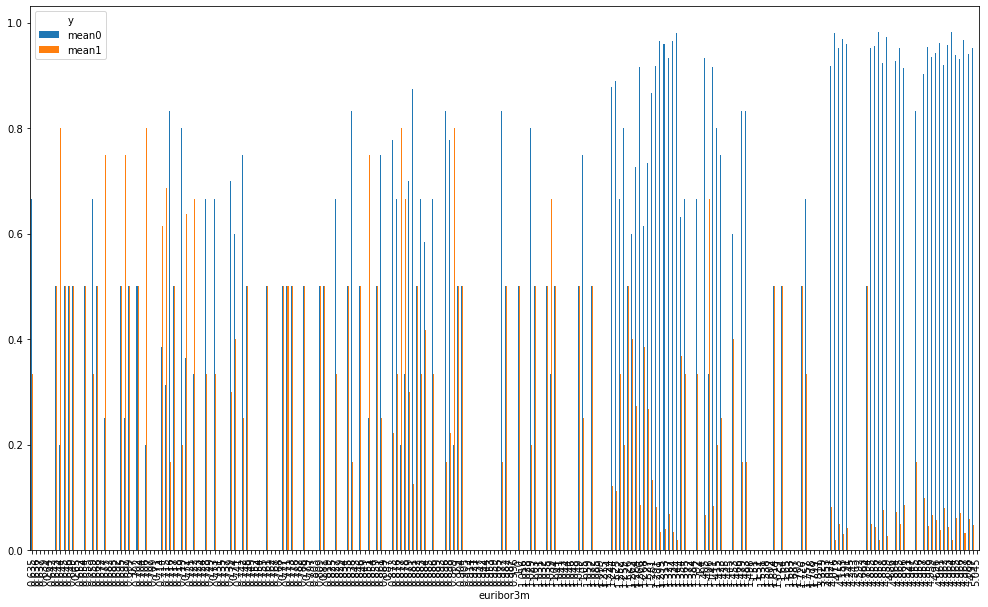

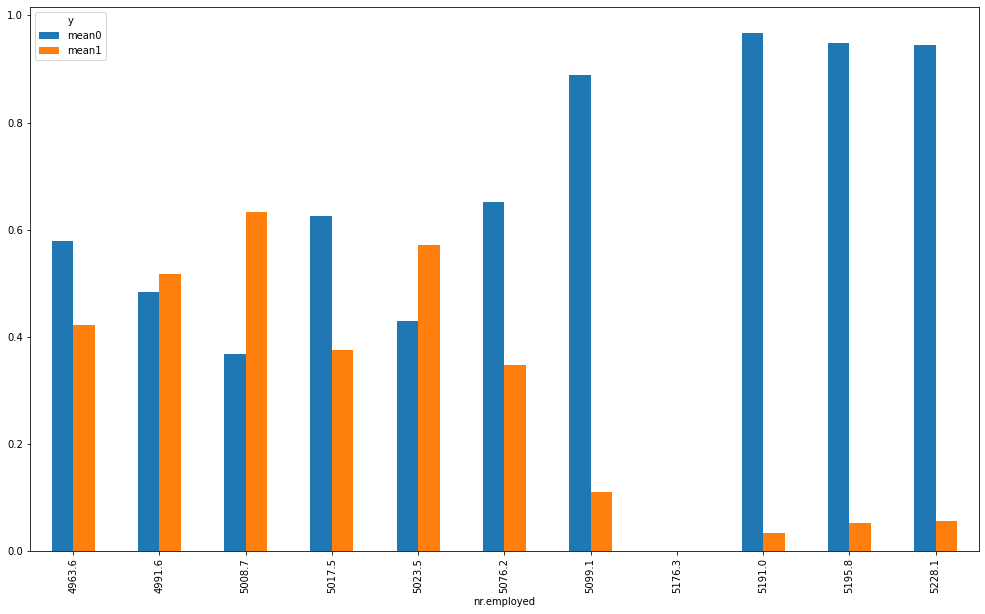

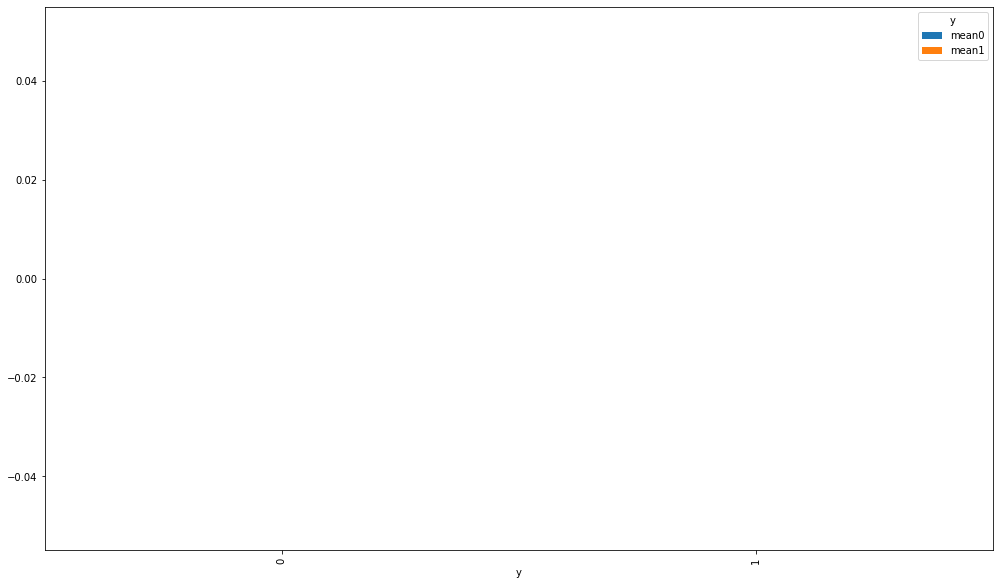

In [36]:
for col in df.columns:
    df_ = df.groupby([col,'y']).size()
    df_ = df_.unstack()
    df_["mean0"] = df_.loc[:, 0] / (df_.loc[:, 0] + df_.loc[:, 1])
    df_["mean1"] = df_.loc[:, 1] / (df_.loc[:, 0] + df_.loc[:, 1])
    df_[['mean0', 'mean1']].plot(kind='bar')

In [7]:
# g = sns.PairGrid(df1)
# g.map_diag(plt.hist)
# g.map_offdiag(plt.bar)
# # counts.to_csv('name.csv',index=False

<AxesSubplot:xlabel='age'>

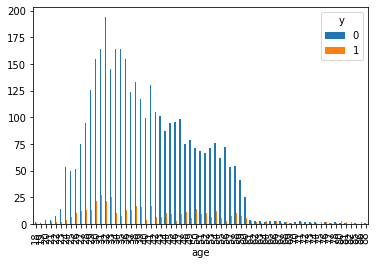

In [28]:
df_ = df1.groupby(['age','y']).size()
df_ = df_.unstack()
df_.plot(kind='bar')

In [26]:
dff = pd.cut(df['age'], bins=5)
dff

0       (17.93, 32.0]
1        (32.0, 46.0]
2       (17.93, 32.0]
3        (32.0, 46.0]
4        (46.0, 60.0]
            ...      
4114    (17.93, 32.0]
4115     (32.0, 46.0]
4116    (17.93, 32.0]
4117     (46.0, 60.0]
4118     (32.0, 46.0]
Name: age, Length: 4119, dtype: category
Categories (5, interval[float64, right]): [(17.93, 32.0] < (32.0, 46.0] < (46.0, 60.0] < (60.0, 74.0] < (74.0, 88.0]]

In [25]:
df.count()

age               4119
job               4119
marital           4119
education         4119
default           4119
housing           4119
loan              4119
contact           4119
month             4119
day_of_week       4119
duration          4119
campaign          4119
pdays             4119
previous          4119
poutcome          4119
emp.var.rate      4119
cons.price.idx    4119
cons.conf.idx     4119
euribor3m         4119
nr.employed       4119
y                 4119
dtype: int64